<div style="display: flex; align-items: center; justify-content: center; text-align: center; flex-direction: row;">
  <img src="https://coursereport-s3-production.global.ssl.fastly.net/uploads/school/logo/219/original/CT_LOGO_NEW.jpg" width="100" style="margin-right: 10px;">

</div>

> 
# <span style="color:#34a853">Project - Cars</span> 🚗

## <span style="color:#4285f4">Analysis by Allison DuBose</span>

### <span style="color:#ea4335">Section 1: Data Reading and Cleansing</span>

#### <span style="color:#ff930f">In this section we will bring in the data set and begin with</span>
#### <span style="color:#ff930f">some general observations about the cars data and what we can </span>
#### <span style="color:#ff930f">do to make it clearer and more useful. </span>

In [1]:
#Starting with Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from rapidfuzz import fuzz, process
import numpy as np
import missingno as msno
import xlsxwriter

In [2]:
#Read in the data:
cars = pd.read_csv('Cars_Datasets_2025.csv', encoding='latin1')

In [3]:
cars.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


In [4]:
cars.describe()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
count,1218,1218,1218,1215,1218,1218,1212,1218,1218,1218,1217
unique,37,1201,356,311,456,114,180,535,23,19,263
top,Nissan,Macan T,I4,"2,000 cc",355 hp,250 km/h,6.5 sec,"$35,000",Petrol,5,400 Nm
freq,149,2,64,31,23,145,45,36,871,692,72


In [5]:
cars.isna().sum()

Company Names                0
Cars Names                   0
Engines                      0
CC/Battery Capacity          3
HorsePower                   0
Total Speed                  0
Performance(0 - 100 )KM/H    6
Cars Prices                  0
Fuel Types                   0
Seats                        0
Torque                       1
dtype: int64

##### <span style="color:#0000f7">Thankfully there not too many nulls. </span>
##### <span style="color:#0000f7">We may be looking at other forms of cleaning though.</span>

In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


##### <span style="color:#0000f7">Here we can see that despite having some numerical data, other values are causing </span>
##### <span style="color:#0000f7">the data to not be seen as numeric. Let's fix that. </span>


In [7]:
# Let's start with the battery column.
cars['CC Capacity'] = cars['CC/Battery Capacity'].str.extract(r'(\d[\d,]*)').replace(',', '', regex=True).astype(float)


In [8]:
# Horsepower has some bigger issues, so let's dive into that.
#First we need to address the 'hp' in the way
def clean_horsepower(hp_str):
    # Remove 'hp' and whitespace
    hp_str = str(hp_str).replace('hp', '').strip()
    #Also, so ranges exist, so let's get a single value:
    if '-' in hp_str:
        try:
            low, high = map(float, hp_str.split('-'))
            return np.median([low, high])
        except ValueError:
            return np.nan
    else:
        try:
            return float(hp_str)
        except ValueError:
            return np.nan   
#Last, let's apply the clean
cars['HorsePower_cleaned'] = cars['HorsePower'].apply(clean_horsepower)

In [9]:
#Lose some extra letters in total speed
cars['speed_km_per_hr'] = cars['Total Speed'].str.extract(r'([\d.]+)').astype(float)

In [10]:
#Now for the performance column
cars['0-100 KMH'] = cars['Performance(0 - 100 )KM/H'].str.extract(r'([\d.]+)').astype(float)


In [11]:
#Much like horsepower, prices have issues with ranges on top of letter, so let's adjust that.

# First we need a process:
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan

    # Remove $ and commas
    price_str = price_str.replace('$', '').replace(',', '').strip()

    # Check if it's a range
    if '-' in price_str:
        try:
            low, high = map(float, price_str.split('-'))
            median_price = np.median([low, high])
            return median_price
        except ValueError:
            return np.nan
    else:
        try:
            return float(price_str)
        except ValueError:
            return np.nan

# Apply cleaning
cars['Price_cleaned'] = cars['Cars Prices'].apply(clean_price)

In [12]:
# More fun with letters and ranges! He we go torque
def clean_torque(torque_str):
    if pd.isna(torque_str):
        return np.nan

    # Remove 'Nm' and whitespace
    torque_str = torque_str.replace('Nm', '').strip()

    # Handle ranges like "100 - 140"
    if '-' in torque_str:
        try:
            low, high = map(float, torque_str.split('-'))
            return np.median([low, high])
        except ValueError:
            return np.nan
    else:
        try:
            return float(torque_str)
        except ValueError:
            return np.nan

# Apply clean
cars['Torque_cleaned'] = cars['Torque'].apply(clean_torque)

In [13]:
cars.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque,CC Capacity,HorsePower_cleaned,speed_km_per_hr,0-100 KMH,Price_cleaned,Torque_cleaned
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm,3990.0,963.0,340.0,2.5,1100000.0,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm,6749.0,563.0,250.0,5.3,460000.0,900.0
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm,1200.0,77.5,165.0,10.5,13500.0,120.0
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm,3982.0,630.0,250.0,3.2,161000.0,900.0
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm,5204.0,602.0,320.0,3.6,253290.0,560.0


In [14]:
dtype = cars.dtypes.reset_index()
dtype.columns = ['column_name', 'data_type']

dtype

,column_name,data_type
0,Company Names,object
1,Cars Names,object
2,Engines,object
3,CC/Battery Capacity,object
4,HorsePower,object
5,Total Speed,object
6,Performance(0 - 100 )KM/H,object
7,Cars Prices,object
8,Fuel Types,object
9,Seats,object


In [15]:
#Let's make this look a little cleaner with a new data frame.
# Define a dictionary mapping of old column names to new ones and leaving behind the cluttered columns
column_rename_map = {
    "Company Names": "Company Names",
    "Cars Names": "Cars Names",
    "Engines": "Engines",
    "Fuel Types": "Fuel Types",
    "Seats": "Seats",
    "CC Capacity": "CC/Battery Capacity",
    "HorsePower_cleaned": "HorsePower",
    "0-100 KMH": "secs_0_to_100_kmh",
    "speed_km_per_hr": "speed_km_per_hr",
    "Price_cleaned": "Price_USD",
    "Torque_cleaned": "Torque"
}

# Create the cleaned DataFrame by selecting applying the changes
cars_cleaned = cars[list(column_rename_map.keys())].rename(columns=column_rename_map)


In [16]:
#Let's see that new, shiny data
cars_cleaned.head()

,Company Names,Cars Names,Engines,Fuel Types,Seats,CC/Battery Capacity,HorsePower,secs_0_to_100_kmh,speed_km_per_hr,Price_USD,Torque
0,FERRARI,SF90 STRADALE,V8,plug in hyrbrid,2,3990.0,963.0,2.5,340.0,1100000.0,800.0
1,ROLLS ROYCE,PHANTOM,V12,Petrol,5,6749.0,563.0,5.3,250.0,460000.0,900.0
2,Ford,KA+,1.2L Petrol,Petrol,5,1200.0,77.5,10.5,165.0,13500.0,120.0
3,MERCEDES,GT 63 S,V8,Petrol,4,3982.0,630.0,3.2,250.0,161000.0,900.0
4,AUDI,AUDI R8 Gt,V10,Petrol,2,5204.0,602.0,3.6,320.0,253290.0,560.0


In [17]:
#Oops - one last one - lets get those seats fixed.
#Seats have two problems: we have ranges and we have 2+2 instead of 4. Let's fix both.
def clean_seats(seat_value):
    if pd.isna(seat_value):
        return np.nan

    seat_str = str(seat_value).strip()

    if '+' in seat_str:            # case: '2+2' → 4
        try:
            parts = map(int, seat_str.split('+'))
            return sum(parts)
        except:
            return np.nan

    elif '-' in seat_str:          # case: '2-12' → 12 (top of range)
        try:
            return int(seat_str.split('-')[1])
        except:
            return np.nan

    else:                          # case: '5' → 5
        try:
            return int(seat_str)
        except:
            return np.nan

# Overwrite Seats column in cars_cleaned
cars_cleaned['Seats'] = cars_cleaned['Seats'].apply(clean_seats)


In [18]:
#Now how are we looking on nulls?
missing_df = cars_cleaned.isna().sum().reset_index()
missing_df.columns = ['Column', 'Missing Values']
missing_df

,Column,Missing Values
0,Company Names,0
1,Cars Names,0
2,Engines,0
3,Fuel Types,0
4,Seats,7
5,CC/Battery Capacity,5
6,HorsePower,189
7,secs_0_to_100_kmh,6
8,speed_km_per_hr,0
9,Price_USD,6


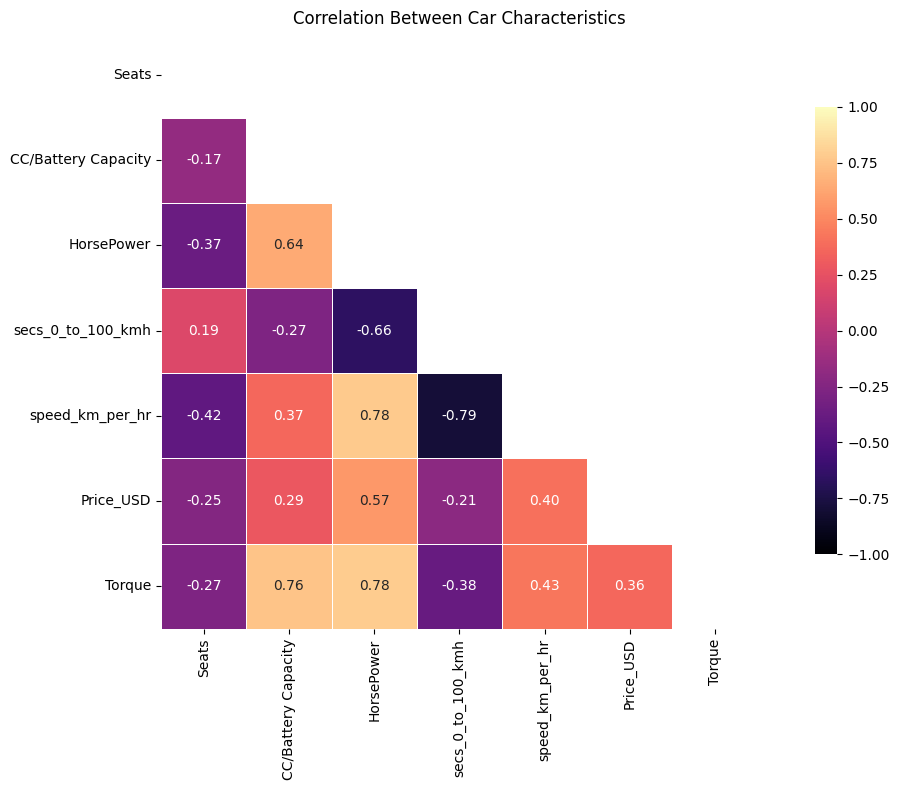

In [19]:
#Oof looks like we picked up some. Let's see who we can ask for help.
#Choosing which columns to heat map:
num_cols = cars_cleaned.select_dtypes(include='number').columns.tolist()
corr_data = cars_cleaned[num_cols].dropna()

# Setting the correlation:
corr = corr_data.corr()

# Mapping the duplicate data mask:
mask = np.triu(np.ones_like(corr, dtype=bool))

# Select a figure size:
plt.figure(figsize=(12, 8))

# Get the map:
sns.heatmap(
    corr, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='magma', 
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    vmin = -1,
    vmax = 1
)

plt.title('Correlation Between Car Characteristics')
plt.tight_layout()
plt.show()


Looks like horsepower has a pretty strong correlation with torque and speed, so that can help.
Some of these are not going to be huge focus areas because they are not key metrics we are looking for today or it is so few, that we will remove them from the data set. For the rest, we will try to use similar atributes and fill in where we can.


In [20]:
#First, let's rip off the bandaid and drop where we can.
cars_cleaned = cars_cleaned.dropna(subset=['Seats', 'secs_0_to_100_kmh', 'Price_USD'])

In [21]:
# Next let's look at the battery column.
def impute_cc(row, df):
    if pd.notna(row['CC/Battery Capacity']):
        return row['CC/Battery Capacity']

    similar = df[
        (df['Engines'] == row['Engines']) &
        (df['HorsePower'].between(row['HorsePower'] - 50, row['HorsePower'] + 50)) &
        (df['Torque'].between(row['Torque'] - 100, row['Torque'] + 100)) &
        (df['CC/Battery Capacity'].notna())
    ]

    if not similar.empty:
        return similar['CC/Battery Capacity'].mean()
    return np.nan

cars_cleaned['CC/Battery Capacity'] = cars_cleaned.apply(lambda row: impute_cc(row, cars_cleaned), axis=1)

In [22]:
# And now for the biggest set of missing values, horsepower.
def impute_hp(row, df):
    if pd.notna(row['HorsePower']):
        return row['HorsePower']

    similar = df[
        (df['Engines'] == row['Engines']) &
        (df['speed_km_per_hr'].between(row['speed_km_per_hr'] - 20, row['speed_km_per_hr'] + 20)) &
        (df['Torque'].between(row['Torque'] - 100, row['Torque'] + 100)) &
        (df['HorsePower'].notna())
    ]

    if not similar.empty:
        return similar['HorsePower'].mean()
    return np.nan

cars_cleaned['HorsePower'] = cars_cleaned.apply(lambda row: impute_hp(row, cars_cleaned), axis=1)


In [23]:
# Still a few more steps - Torque
def impute_torque(row, df):
    if pd.notna(row['Torque']):
        return row['Torque']

    similar = df[
        (df['Engines'] == row['Engines']) &
        (df['speed_km_per_hr'].between(row['speed_km_per_hr'] - 20, row['speed_km_per_hr'] + 20)) &
        (df['HorsePower'].between(row['HorsePower'] - 50, row['HorsePower'] + 50)) &
        (df['Torque'].notna())
    ]

    if not similar.empty:
        return similar['Torque'].mean()
    return np.nan

cars_cleaned['Torque'] = cars_cleaned.apply(lambda row: impute_torque(row, cars_cleaned), axis=1)

In [24]:
# Let's see where we are now:
missing_df = cars_cleaned.isna().sum().reset_index()
missing_df.columns = ['Column', 'Missing Values']
missing_df

,Column,Missing Values
0,Company Names,0
1,Cars Names,0
2,Engines,0
3,Fuel Types,0
4,Seats,0
5,CC/Battery Capacity,2
6,HorsePower,132
7,secs_0_to_100_kmh,0
8,speed_km_per_hr,0
9,Price_USD,0


In [25]:
#A surprising number still missing, but for our purposes, we have enough for the analysis without having all.
cars_cleaned = cars_cleaned.dropna(subset=[
    'CC/Battery Capacity', 'HorsePower', 'Torque'
])


In [26]:
# Sorry friends. Off with their head.
missing_df = cars_cleaned.isna().sum().reset_index()
missing_df.columns = ['Column', 'Missing Values']
missing_df

,Column,Missing Values
0,Company Names,0
1,Cars Names,0
2,Engines,0
3,Fuel Types,0
4,Seats,0
5,CC/Battery Capacity,0
6,HorsePower,0
7,secs_0_to_100_kmh,0
8,speed_km_per_hr,0
9,Price_USD,0


### <span style="color:#ea4335">Section 2: Interpreting and Analyzing the Data</span>

#### <span style="color:#ff930f">In this section we will start looking at some statistics and correlations.</span>
#### <span style="color:#ff930f">We will look at some visuals and see what we can find out about the data. </span>
#### <span style="color:#ff930f">Then we will make some observations about what we see. </span>

Let's dive in. First we will start with some simple correlations and build from there.

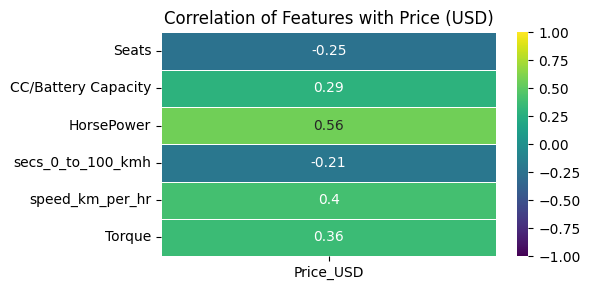

In [27]:
# What are the main factors driving price?

numeric_df = cars_cleaned.select_dtypes(include='number')

price_corr = numeric_df.corr()[['Price_USD']].drop('Price_USD')

#Plot heatmap
plt.figure(figsize=(6, len(price_corr) * 0.5))
sns.heatmap(price_corr, annot=True, cmap='viridis', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation of Features with Price (USD)')
plt.tight_layout()
plt.show()



Looks like horsepower is the main factor influencing price, however none independently have a strong correlation. Looking at seats and seconds to go from 0 to 100 kmh, we see that there is a negative relationship showing a proclivity for people to pay more for sports cars.

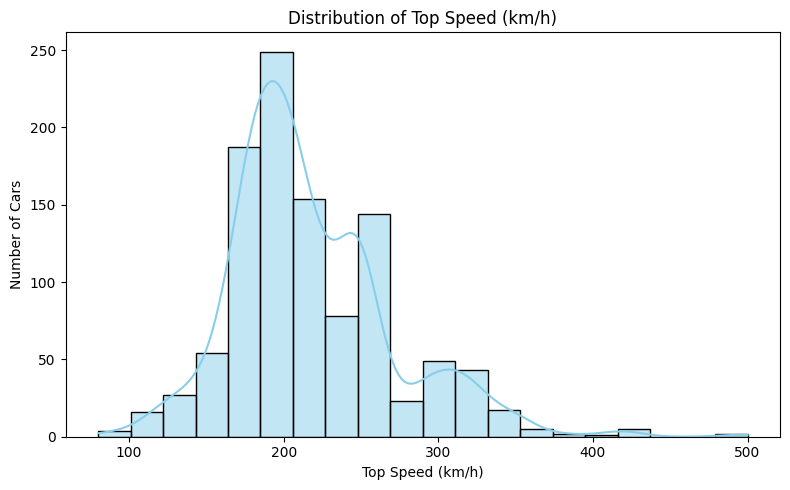

In [28]:
# What's the top speed?
plt.figure(figsize=(8, 5))
sns.histplot(data=cars_cleaned, x='speed_km_per_hr', bins=20, kde=True, color='skyblue')
plt.title('Distribution of Top Speed (km/h)')
plt.xlabel('Top Speed (km/h)')
plt.ylabel('Number of Cars')
plt.tight_layout()
plt.show()

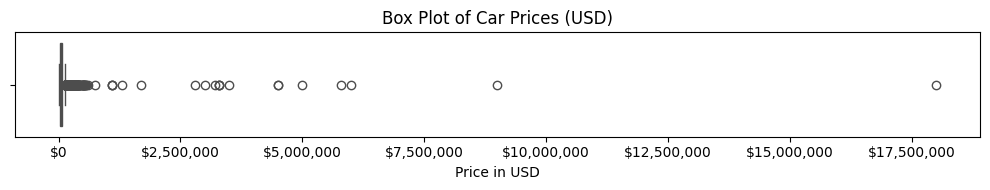

In [29]:
#What is the distribution of prices?
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 2))
sns.boxplot(data=cars_cleaned, x='Price_USD', color='orange')

plt.title('Box Plot of Car Prices (USD)')
plt.xlabel('Price in USD')

# Format x-axis as currency
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Oh no! Looks the outliers are skewing the data. Let's fix that.

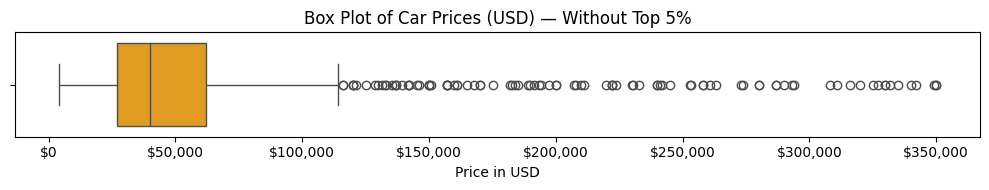

In [30]:
# Remove top 5% of prices
threshold = cars_cleaned['Price_USD'].quantile(0.95)
filtered_df = cars_cleaned[cars_cleaned['Price_USD'] <= threshold]

plt.figure(figsize=(10, 2))
sns.boxplot(data=filtered_df, x='Price_USD', color='orange')
plt.title('Box Plot of Car Prices (USD) — Without Top 5%')
plt.xlabel('Price in USD')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.tight_layout()
plt.show()


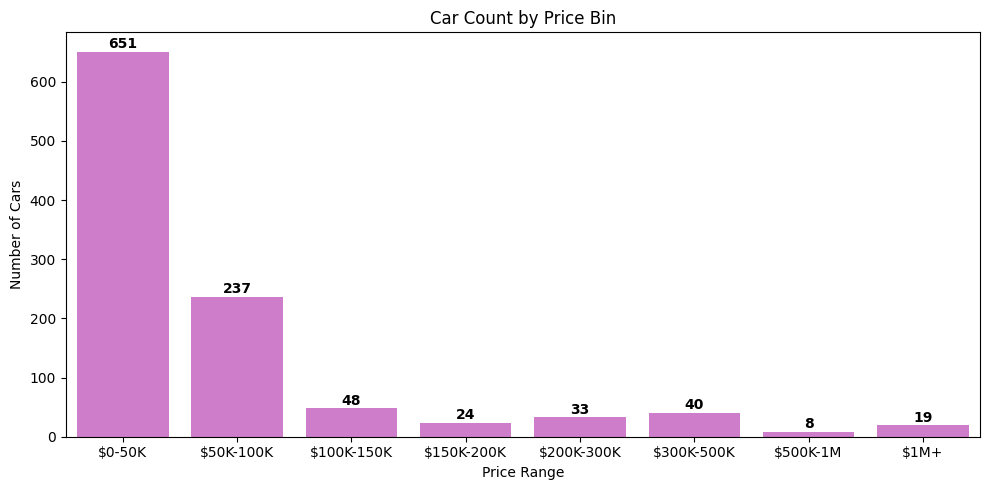

In [31]:
#That looks better, but we stil have a lot of outliers. Let's look at that.

# Define custom bins
bins = [0, 50000, 100000, 150000, 200000, 300000, 500000, 1_000_000, float('inf')]
labels = ['$0-50K', '$50K-100K', '$100K-150K', '$150K-200K', '$200K-300K', 
          '$300K-500K', '$500K-1M', '$1M+']

cars_cleaned['Price Bin'] = pd.cut(cars_cleaned['Price_USD'], bins=bins, labels=labels)

# Plot
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=cars_cleaned, x='Price Bin', color='orchid')

# Add count labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,  # adjust this value to fine-tune spacing
        int(height),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Titles and labels
plt.title('Car Count by Price Bin')
plt.xlabel('Price Range')
plt.ylabel('Number of Cars')
plt.tight_layout()
plt.show()


##### <span style="color:#0000f7">So the majority of cars are under $100k, but there are people paying over a million for a car!</span>


Text(0, 0.5, 'Company')

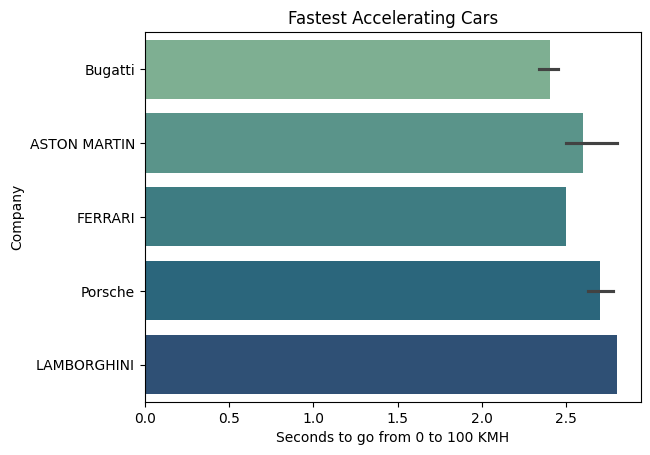

In [32]:
#What are the best performing cars?

top_acceleration = cars_cleaned.sort_values('secs_0_to_100_kmh').head(20)
sns.barplot(data=top_acceleration, y='Company Names', x='secs_0_to_100_kmh', hue= 'Company Names', palette= 'crest')  # Fixed 'pallete' to 'palette'
# Titles and labels
plt.title('Fastest Accelerating Cars')
plt.xlabel('Seconds to go from 0 to 100 KMH')
plt.ylabel('Company')

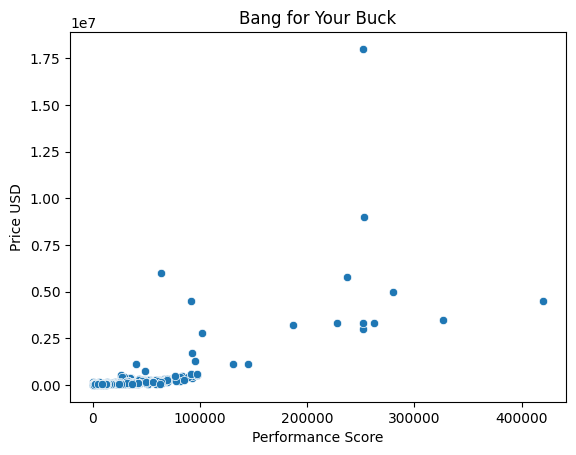

In [33]:

# Calculate the performance score and add it to the DataFrame
cars_cleaned['performance_score'] = (cars_cleaned['HorsePower'] * cars_cleaned['speed_km_per_hr']) / cars_cleaned['secs_0_to_100_kmh']

# Now create the scatterplot using the column from the DataFrame
sns.scatterplot(data=cars_cleaned, x='performance_score', y='Price_USD')
# Titles and labels
plt.title('Bang for Your Buck')
plt.xlabel('Performance Score')
plt.ylabel('Price USD');

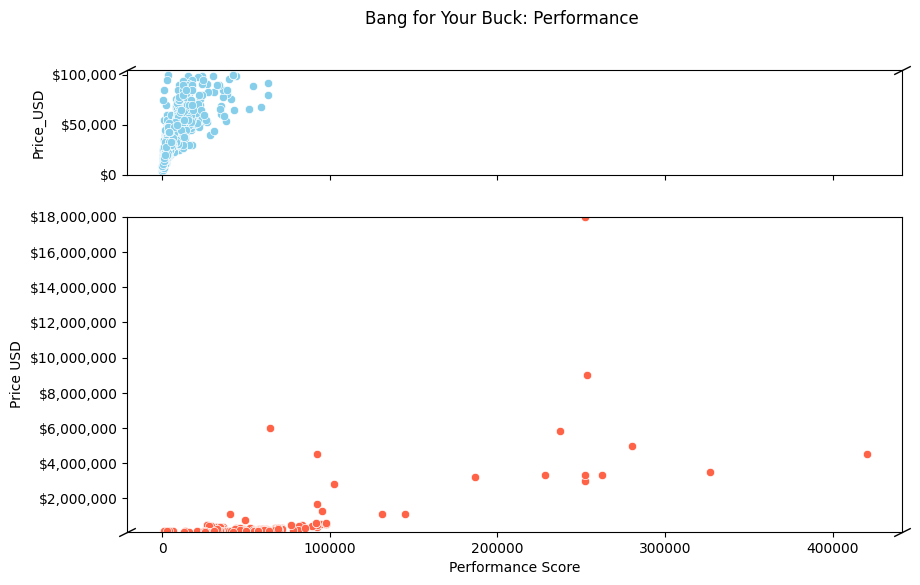

In [34]:
# Are the Most Expensive Cars Worth It (Performance-Wise)?

#Making two subplots with shared x-axis because of outliers
fig, (ax_low, ax_high) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})

#Define the break
break_point = 100000

# Plot lower-priced cars (<= $100K)
sns.scatterplot(
    data=cars_cleaned[cars_cleaned['Price_USD'] <= break_point],
    x='performance_score',
    y='Price_USD',
    ax=ax_low,
    color='skyblue'
)

# Plot high-priced cars (> $100K)
sns.scatterplot(
    data=cars_cleaned[cars_cleaned['Price_USD'] > break_point],
    x='performance_score',
    y='Price_USD',
    ax=ax_high,
    color='tomato'
)

# Adjust y-limits
ax_low.set_ylim(0, 105000)
ax_high.set_ylim(105000, cars_cleaned['Price_USD'].max())

# Format y-axes as USD
import matplotlib.ticker as mtick
ax_low.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax_high.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))


# Add "zigzag" lines to show the break visually
kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax_low.plot([0, 1], [1, 1], transform=ax_low.transAxes, **kwargs)
ax_high.plot([0, 1], [0, 0], transform=ax_high.transAxes, **kwargs)

# Labels and title
fig.suptitle('Bang for Your Buck: Performance');
plt.xlabel('Performance Score')
plt.ylabel('Price USD');

As we can see here, the cause for the higher prices do not seem to be indicated in the typical performance metrics.

In [35]:
cars_cleaned['Fuel Types'].unique()

array(['plug in hyrbrid', 'Petrol', 'Diesel', 'Hybrid', 'Electric',
       'Petrol/Diesel', 'Plug-in Hybrid', 'Petrol/AWD', 'Petrol/Hybrid',
       'Hydrogen', 'Diesel/Petrol', 'Petrol/EV', 'Hybrid/Electric',
       'Petrol, Hybrid', 'Petrol, Diesel', 'CNG/Petrol', 'Hybrid/Petrol'],
      dtype=object)

In [36]:
# Does fuel type affect HorsePower?

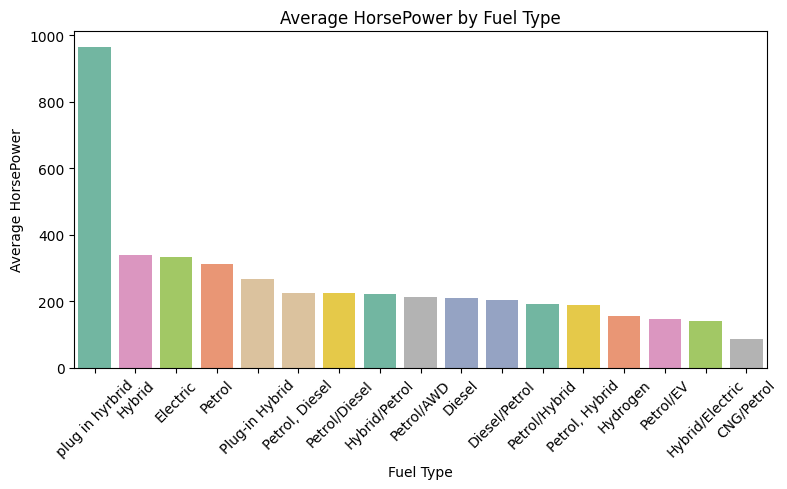

In [37]:
order = cars_cleaned.groupby('Fuel Types')['HorsePower'].mean().sort_values(ascending=False).index

# Set plot size and style
plt.figure(figsize=(8, 5))
sns.barplot(data=cars_cleaned, x='Fuel Types', y='HorsePower', estimator='mean', errorbar=None, hue= 'Fuel Types', palette='Set2', order=order)

# Titles and labels
plt.title('Average HorsePower by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average HorsePower')

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()



A lot of people claim to not drive hybrid or electric because of the diminished towing capacity, but based on this chart, that doesn't seem to be the case.

In [38]:
#Looking at more value metrics
cars_cleaned['USD_per_HP'] = cars_cleaned['Price_USD'] / cars_cleaned['HorsePower']
cars_cleaned['USD_per_Torque'] = cars_cleaned['Price_USD'] / cars_cleaned['Torque']

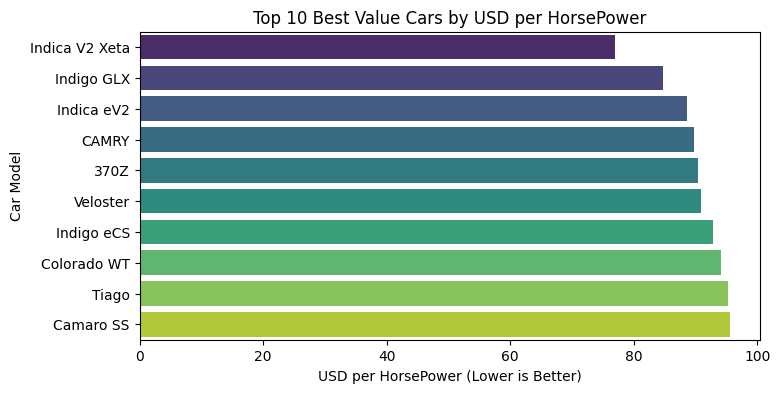

In [39]:
# Plotting the new metrics, what is the best value?
# Sort by USD per HP (lowest = best value)
best_value_hp = cars_cleaned.sort_values(by='USD_per_HP').head(10)

# Plot
plt.figure(figsize=(8,4))
sns.barplot(
    data=best_value_hp,
    y='Cars Names',   # barh-style: car names on Y-axis
    x='USD_per_HP',
    hue='Cars Names', 
    palette='viridis'
)

plt.title('Top 10 Best Value Cars by USD per HorsePower')
plt.xlabel('USD per HorsePower (Lower is Better)')
plt.ylabel('Car Model')

plt.show()

As we can see, the best value are going to be in those base model cars like Toyota and Chevy.